In [1]:
import time
import random
import numpy as np
import sys
import pickle
import h5py
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import torch
import learn2learn as l2l
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR
from functions.fftc import fft2c_new as fft2c
from functions.fftc import ifft2c_new as ifft2c
from functions.math import complex_abs, complex_mul, complex_conj
# The corase reconstruction is the rss of the zerofilled multi-coil kspaces
# after inverse FT.
from functions.data.transforms import UnetDataTransform_sens_TTT, complex_center_crop
# Import a torch.utils.data.Dataset class that takes a list of data examples, a path to those examples
# a data transform and outputs a torch dataset.
from functions.data.mri_dataset import SliceDataset
# Unet architecture as nn.Module
from functions.models.unet import Unet
# Function that returns a MaskFunc object either for generatig random or equispaced masks
from functions.data.subsample import create_mask_for_mask_type
# Implementation of SSIMLoss
from functions.training.losses import SSIMLoss
from functions.helper import evaluate2c_imagepair
### after you install bart 0.7.00 from https://mrirecon.github.io/bart/, import it as follows
sys.path.insert(0,'/cheng/bart-0.7.00/python/')
os.environ['TOOLBOX_PATH'] = "/cheng/bart-0.7.00/"
import bart

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# seed
SEED = 1
random.seed(SEED)
np.random.seed(SEED)
torch.cuda.manual_seed(SEED)
torch.manual_seed(SEED)


### Load the data

In [2]:
# data path
path_train = '/cheng/metaMRI/metaMRI/data_dict_narrowSlices/brain_train_test.yaml'

# mask function and data transform
mask_function = create_mask_for_mask_type(mask_type_str = 'random', self_sup = False, 
                    center_fraction = 0.08, acceleration = 4.0, acceleration_total = 3.0)

data_transform = UnetDataTransform_sens_TTT('multicoil', mask_func = mask_function, use_seed=True, mode='adapt')

# training dataset and data loader
trainset = SliceDataset(dataset = path_train, path_to_dataset='', 
                path_to_sensmaps='/cheng/metaMRI/metaMRI/data_sensmaps/', 
                provide_senmaps=True, 
                challenge="multicoil", 
                transform=data_transform, 
                use_dataset_cache=True)

input_image, target_image, mean, std, fname, slice_num, input_kspace, input_mask, target_kspace, target_mask, sens_maps = trainset[0]

In [3]:
input_kspace.shape

torch.Size([20, 640, 320, 2])

In [4]:
input_mask.shape

torch.Size([1, 1, 320, 1])

In [5]:
input_image.shape

torch.Size([2, 640, 320])

In [6]:
target_image.shape

torch.Size([1, 640, 320])

In [7]:
sens_maps.shape

torch.Size([20, 640, 320, 2])

### Load the model

In [8]:
# INIT = 'maml'   # 'standard', 'maml'

# # different trained weight
# if INIT == 'standard':
#     checkpoint_path = "/cheng/metaMRI/metaMRI/save/E6*/E6.6_standard(NMSE-lrAnneal)_T8x200_100epoch_E85_best.pth"
# elif INIT == 'maml':
#     checkpoint_path = "/cheng/metaMRI/metaMRI/save/E6*/E6.4_maml(NMSE-lre-3)_T8x200_200epoch_E200_best.pth"
# else: 
#     print('Choose the initialization weight. ')

model = Unet(in_chans=2, out_chans=2, chans=32, num_pool_layers=4, drop_prob=0.0)
#model.load_state_dict(torch.load(checkpoint_path))
model = model.to(device)

### k-space under-sampling mask visualization

(16, 20, 640, 320)


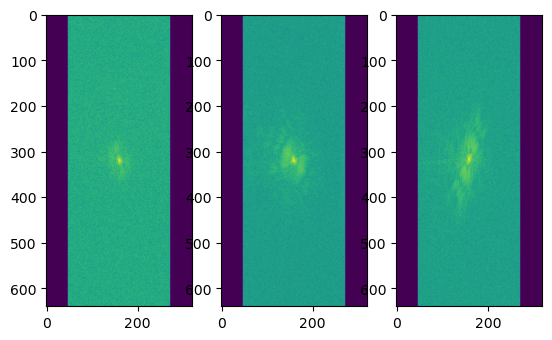

In [9]:
file_name = '/media/hdd1/fastMRIdata/brain/multicoil_train/file_brain_AXFLAIR_200_6002549.h5'
hf = h5py.File(file_name)
volume_kspace = hf['kspace'][()]
print(volume_kspace.shape)
slice_kspace = volume_kspace[4] # Choosing the 5-th slice of this volume
def show_coils(data, slice_nums, cmap=None):
    fig = plt.figure()
    for i, num in enumerate(slice_nums):
        plt.subplot(1, len(slice_nums), i + 1)
        plt.imshow(data[num], cmap=cmap)
show_coils(np.log(np.abs(slice_kspace) + 1e-9), [0, 5, 10])  # This shows coils 0, 5 and 10

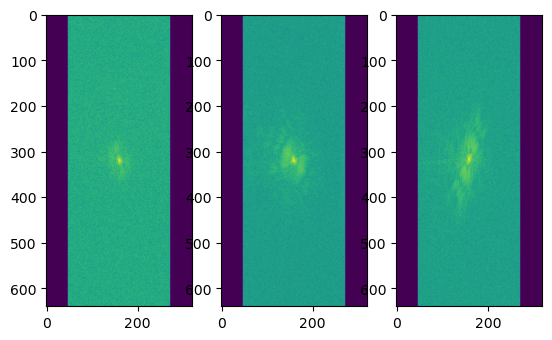

In [10]:
show_coils(np.log(np.abs(slice_kspace * np.array(target_mask.squeeze(3))) + 1e-9), [0, 5, 10])

### Inference without test-time training

In [11]:
l1_loss, nmse_loss, psnr_loss, ssim_loss, output_image, output_image_1c = evaluate2c_imagepair(model, input_image, target_image, mean, std)
print('L1_loss: ', l1_loss)
print('NMSE: ', nmse_loss)
print('PSNR: ', psnr_loss)
print('SSIM: ', ssim_loss)

Inference time:  2.4614386558532715
L1_loss:  1.4639432430267334
NMSE:  0.7611923813819885
PSNR:  13.535476684570312
SSIM:  0.04243206977844238


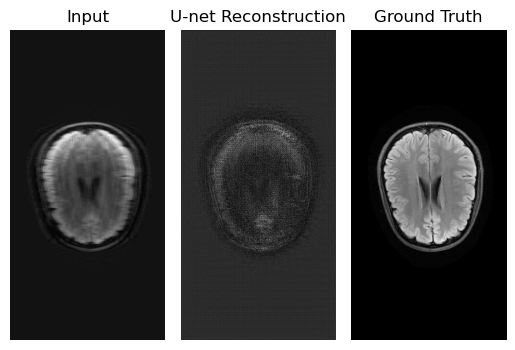

In [12]:
input_image_plot = complex_abs(torch.moveaxis(((input_image - mean)/std).unsqueeze(0) , 1, -1 )).squeeze(0).squeeze(0).cpu().detach().numpy()

fig, axes = plt.subplots(1, 3)

axes[0].imshow(input_image_plot,cmap='gray')
axes[0].set_title('Input')
axes[0].axis('off')

axes[1].imshow(output_image_1c.squeeze(0).squeeze(0).cpu().detach().numpy(),cmap='gray')
axes[1].set_title('U-net Reconstruction')
axes[1].axis('off')

axes[2].imshow(target_image.squeeze(0).squeeze(0).cpu().detach().numpy(),cmap='gray')
axes[2].set_title('Ground Truth')
axes[2].axis('off')

plt.subplots_adjust(wspace=0.1)
plt.show()

In [10]:
# from functions.data.transforms import to_tensor
# sens_map_dir = '/cheng/metaMRI/metaMRI/data_sensmaps/'
# with h5py.File(sens_map_dir + fname + '_smaps_slice' + str(slice_num) + '.h5', "r") as hf:
#     sens_maps = hf["sens_maps"][()]
# sens_maps = to_tensor(sens_maps)
# sens_maps.shape

### Inference with test-time training

$f_{\boldsymbol{\theta}}\left(\mathbf{A}^{\dagger} \mathbf{y}_i\right)$

In [20]:
### make a forward pass
l1_loss, nmse_loss, psnr_loss, ssim_loss, output_image, output_image_1c = evaluate2c_imagepair(model, input_image, target_image, mean, std)
output_image = torch.moveaxis( output_image , 1, -1 )
output_image.shape

Inference time:  0.018198251724243164


torch.Size([1, 640, 320, 2])

$\operatorname{S}_i $

torch.Size([20, 640, 320, 2])


(-0.5, 319.5, 639.5, -0.5)

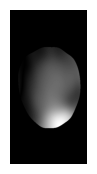

In [21]:
print(sens_maps.shape)
fig = plt.figure(figsize=(1,2))
ax = fig.add_subplot(111)
ax.imshow(np.abs(sens_maps[0, :, :, 0]),'gray')
ax.axis('off')

$\operatorname{S}_i f_{\boldsymbol{\theta}}\left(\mathbf{A}^{\dagger} \mathbf{y}_i\right)$

In [29]:
sens_maps = sens_maps.to(device)

output_sens_image = complex_mul(output_image, sens_maps)
output_sens_image.shape

torch.Size([20, 640, 320, 2])

$\operatorname{FS}_i f_{\boldsymbol{\theta}}\left(\mathbf{A}^{\dagger} \mathbf{y}_i\right)$

In [35]:
Fimg = fft2c(output_sens_image)
Fimg.shape

torch.Size([20, 640, 320, 2])

$\operatorname{M}$

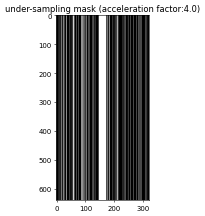

In [36]:
mask_mtx = np.tile(np.array(input_mask.squeeze(0).squeeze(0).squeeze(1)), (target_kspace.shape[1], 1))
plt.figure(dpi=50)
plt.imshow(mask_mtx,'gray')
plt.title('under-sampling mask (acceleration factor:{})'.format(np.round(mask_mtx.shape[1]/np.sum(mask_mtx[0]),2)))
plt.show()

In [37]:
input_mask = input_mask.to(device)
input_mask.shape

torch.Size([1, 1, 320, 1])

$\mathbf{A} f_{\boldsymbol{\theta}}\left(\mathbf{A}^{\dagger} \mathbf{y}_i\right) = \operatorname{MFS}_i f_{\boldsymbol{\theta}}\left(\mathbf{A}^{\dagger} \mathbf{y}_i\right)$

In [38]:
Fimg_forward = Fimg * input_mask
Fimg_forward.shape

torch.Size([20, 640, 320, 2])

$\mathbf{y}_i$

In [39]:
input_kspace = input_kspace.to(device)
input_kspace.shape

torch.Size([20, 640, 320, 2])

$\frac{\left\|\mathbf{y}_i-\mathbf{A} f_{\boldsymbol{\theta}}\left(\mathbf{A}^{\dagger} \mathbf{y}_i\right)\right\|_1}{\left\|\mathbf{y}_i\right\|_1}$

In [40]:
l1_loss = torch.nn.L1Loss(reduction='sum')
loss_self = l1_loss(Fimg_forward, input_kspace) / torch.sum(torch.abs(input_kspace))

In [41]:
loss_self

tensor(1.1966, device='cuda:0', grad_fn=<DivBackward0>)

In [25]:
input_image = input_image.to(device)
input_image.shape

torch.Size([2, 640, 320])

In [26]:
torch.moveaxis( model(input_image.unsqueeze(0)) , 1, -1 ).shape

torch.Size([1, 640, 320, 2])

In [27]:
input_kspace.shape

torch.Size([20, 640, 320, 2])

### Scaling function
The under-sampled $k$-space input is scaled such that the norm of output image is close to the norm of the input image. 

In [28]:
def scale_factor(input_image, input_kspace, model):
    # input_image: [2,320,320]

    for k in range(5):
        # output = [1,640,320,2]
        output_image = torch.moveaxis( model(input_image) , 1, -1 ) 

        if k == 0:
            input_kspace_scale = input_kspace * torch.norm(output_image.detach()) / torch.norm(input_image.detach())
        else:
            input_kspace_scale *= torch.norm(output_image.detach()) / torch.norm(input_image.detach())
        
        input_image = torch.moveaxis( rss_complex(ifft2c(input_kspace_scale))[None,:] , -1, 1 )

        scale = (torch.norm(input_kspace_scale) / torch.norm(input_kspace)).data.cpu().numpy()[np.newaxis][0]
    return scale